### Exercise

1. Create a straight line dataset using the linear regression formula (weight * X + bias).
* Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
* Split the data into 80% training, 20% testing.
* Plot the training and testing data so it becomes visual.

2. Build a PyTorch model by subclassing nn.Module.
* Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
* Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
* Once you've constructed the model, make an instance of it and check its state_dict().
**Note:** If you'd like to use nn.Linear() instead of nn.Parameter() you can.

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
* Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
* Write a training loop to perform the appropriate training steps for 300 epochs.
* The training loop should test the model on the test dataset every 20 epochs.

4. Make predictions with the trained model on the test data.
* Visualize these predictions against the original training and testing data(**note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot**).

5. Save your trained model's state_dict() to file.
* Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
* Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [15]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn

In [16]:
weight = 0.3
bias = 0.9
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim = 1)
y = weight + X * bias
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3180],
         [0.3360],
         [0.3540],
         [0.3720],
         [0.3900],
         [0.4080],
         [0.4260],
         [0.4440],
         [0.4620]]))

In [17]:
# creating train/test split
train_split = int(0.8*len(X))  # this means that 80% of the data will be used for training and 20% for testing
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [40]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


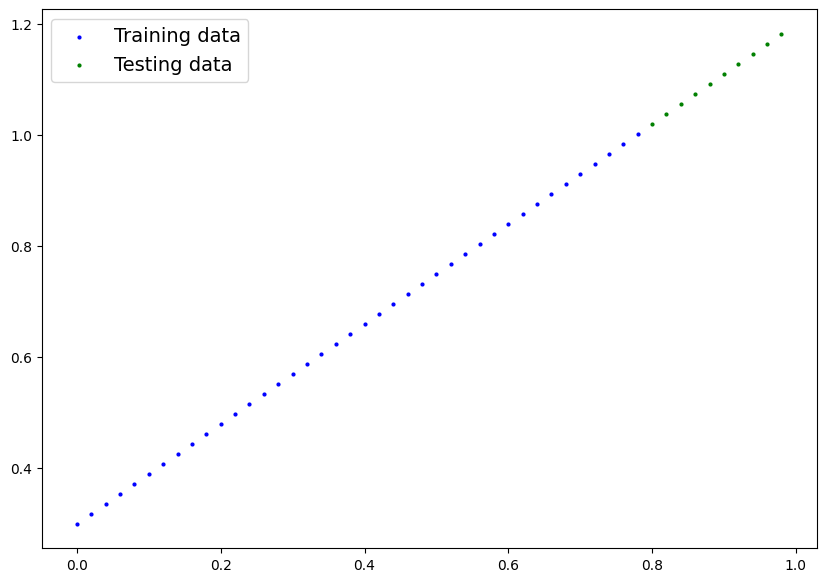

In [41]:
plot_predictions()

In [54]:
# creating a inear regression model

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias

In [66]:
# set a manual seed since nn.Parameter are randomly initiated
torch.manual_seed(42)

#creating an instance of the model
model_0 = LinearRegressionModel()

#check the nn.parameter within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [67]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [68]:
# making predicitons with this model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [69]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


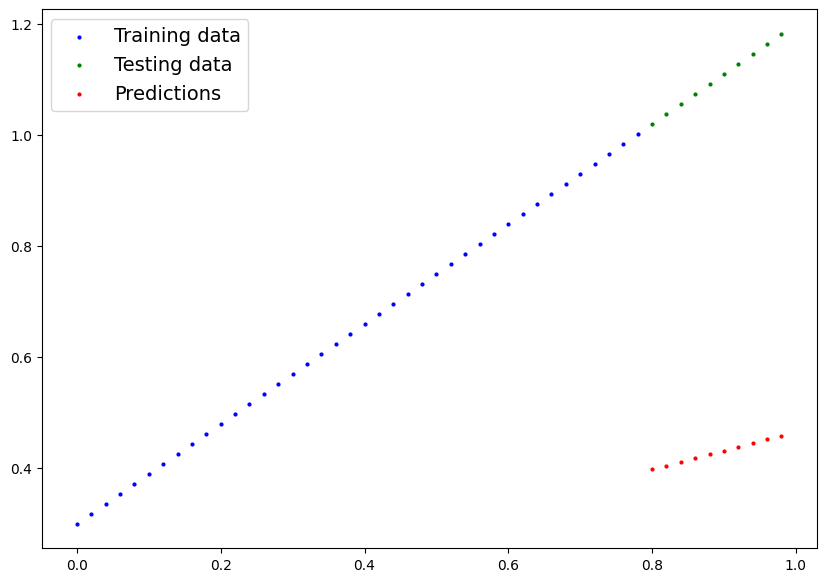

In [70]:
plot_predictions(predictions=y_preds)

In [71]:
y_test - y_preds

tensor([[0.6218],
        [0.6331],
        [0.6444],
        [0.6556],
        [0.6669],
        [0.6782],
        [0.6894],
        [0.7007],
        [0.7120],
        [0.7232]])

In [72]:
# creating the loss function
loss_fn = nn.L1Loss()

# create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)  # # parameters of the target model to optimize

In [73]:
torch.manual_seed(42)

epochs = 300

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  # training

  #puts model in the training mode
  y_pred = model_0(X_train)

  # calculate the loss
  loss = loss_fn(y_pred, y_train)

  # Zero grad of the optimizer
  optimizer.zero_grad()

  # Loss backwards
  loss.backward()

  # Progess the optimizer
  optimizer.step()

  model_0.eval() # puts the model in evaluation mode

  with torch.inference_mode():
    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if(epoch % 10 == 0):
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss : {loss} | MAE Test Loss : {test_loss}")

Epoch: 0 | MAE Train Loss : 0.39088135957717896 | MAE Test Loss : 0.6590651273727417
Epoch: 10 | MAE Train Loss : 0.2756713330745697 | MAE Test Loss : 0.5243551731109619
Epoch: 20 | MAE Train Loss : 0.16460572183132172 | MAE Test Loss : 0.3926808834075928
Epoch: 30 | MAE Train Loss : 0.10852336883544922 | MAE Test Loss : 0.2989806532859802
Epoch: 40 | MAE Train Loss : 0.08743593096733093 | MAE Test Loss : 0.24060264229774475
Epoch: 50 | MAE Train Loss : 0.07890807092189789 | MAE Test Loss : 0.20496833324432373
Epoch: 60 | MAE Train Loss : 0.07424996793270111 | MAE Test Loss : 0.18382300436496735
Epoch: 70 | MAE Train Loss : 0.07052046060562134 | MAE Test Loss : 0.17009106278419495
Epoch: 80 | MAE Train Loss : 0.06703047454357147 | MAE Test Loss : 0.15907101333141327
Epoch: 90 | MAE Train Loss : 0.06354047358036041 | MAE Test Loss : 0.1480509340763092
Epoch: 100 | MAE Train Loss : 0.06010167673230171 | MAE Test Loss : 0.13977840542793274
Epoch: 110 | MAE Train Loss : 0.05666285753250122

In [74]:
print("The model learned the following values of weight and bias: ")
print(model_0.state_dict())
print("The original value of weight and bias")
print(f"weight: {weight}, bias: {bias}")

The model learned the following values of weight and bias: 
OrderedDict([('weights', tensor([0.8940])), ('bias', tensor([0.2968]))])
The original value of weight and bias
weight: 0.3, bias: 0.9


In [75]:
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds


tensor([[1.0120],
        [1.0299],
        [1.0478],
        [1.0656],
        [1.0835],
        [1.1014],
        [1.1193],
        [1.1372],
        [1.1550],
        [1.1729]])

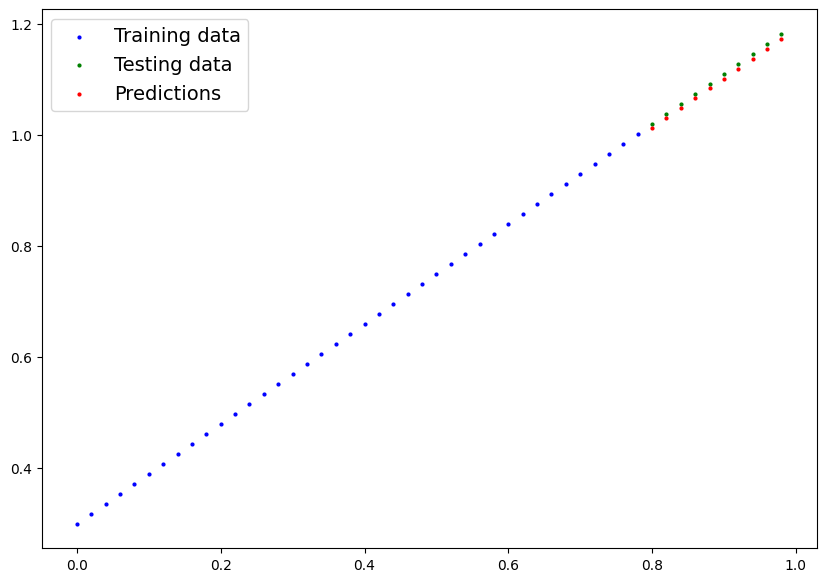

In [76]:
plot_predictions(predictions = y_preds)